# Active learning example


*Active learningis* a specific approach in machine learning where a a model canachieve better performance with a lower amount of training instances (see Figure below). The instances are queried in a clever way out of a large pool of unlabeled instances. The queried instances are then annotated by an oracle (e.g human annotator). Once these queried instances have been annotated, they canbe used to improve the initial model. There are different approaches for querying instances to the oracle; they will be covered in the following subsections

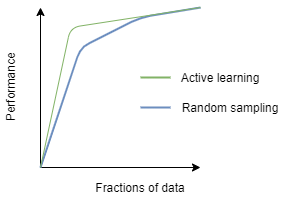




## Initial plotting

Create a toy data set, two gaussians with standard deviation of 1 and centers at [-3,0] and [3,0]


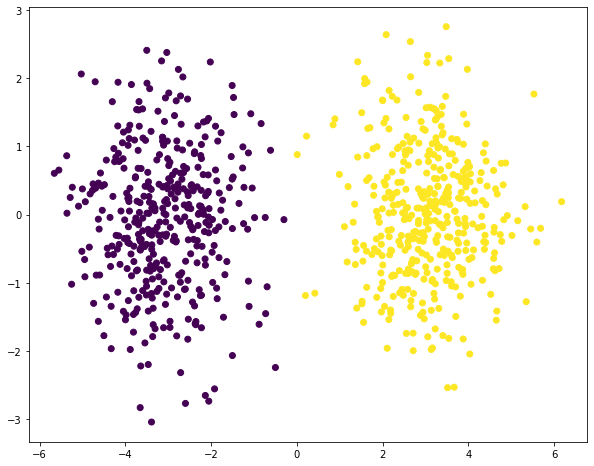

In [45]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

X, y = make_blobs(n_samples=[400,400], centers= [[-3,0],[3,0]], n_features=2,
                  random_state=0, cluster_std=[1,1])

fig, axes = plt.subplots(figsize=(10,8))
axes.scatter(X[:,0], X[:,1], c=y)


samplesize = 20




## Random sampling


Randomly sample 30 samples and train a logistic regression model. Plot the decision boundary and the 30 selected samples (plot these samples as downard triangles)

            

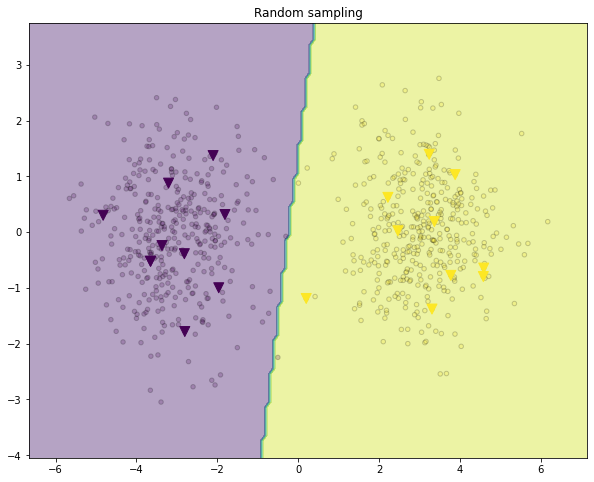

In [79]:
from sklearn.linear_model import LogisticRegression
from itertools import product

sampleIndex = np.random.choice(X.shape[0], samplesize)


clf = LogisticRegression(random_state=0).fit(X[sampleIndex[:],:], y[sampleIndex[:]])


# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(sharex='col', sharey='row', figsize=(10, 8))

idx = product([0, 1], [0, 1])

#print(idx[0])
#print(idx[1])

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
axarr.contourf(xx, yy, Z, alpha=0.4)
axarr.scatter(X[:, 0], X[:, 1], c=y,s=20, edgecolor='k', alpha =.2)
axarr.scatter(X[sampleIndex[:],0], X[sampleIndex[:],1], c=y[sampleIndex[:]], s=100, marker = "v")
axarr.set_title('Random sampling')

plt.show()



It can be seen above that the 30 randomly selected samples do not compute an good model (the decision boundary is somewhat sloped when it be a vertical line right in the middle of the two clusters). Is there a way to select the samples more cleverly rather than randomly sampling ?

## Uncertainty sampling

*Uncertainty sampling* is an active learning approach in which the most "uncertain"instances are queried to the oracle [1]. The "uncertainness" of each sample is com-puted from an initial machine learning model using some informativeness measures(see subsection 2.3.3). Figure 2.5 compares a classifier trained on actively queriedand randomly queried instances on a toy example.

### Informative measures


An *informativeness measure* is a heuristic measure used to determine which instances should be annotated from a large pool of unlabeled data. There are three informative measurements: least confident, margin, and entropy.

*Least confident* is the simplest informativeness measure and involves choosing instance *x* in which the model is least confident, in a binary classification task. The queried instance can formulated as follows
\begin{equation}
    \text{arg}\max_x 1 - P_{\theta}(\hat{y} | x)
\end{equation}
Where $\hat{y} = \text{arg}\max_y P_{\theta}(y | x)$ is the highest posterior probability for the model $\theta$ (the predicted class label for input *x* [1]. This informativeness measure only takes into account the class in which the model is least confident and therefore does not distinguish well between classes in multi-class classification. The following measure takes into account the top two classes:
\begin{equation}
    \text{arg}\min_x P_{\theta}(\hat{y}_1 | x) - P_{\theta}(\hat{y}_2 | x)
\end{equation}
Where $\hat{y}_1$ is the most probable class and $\hat{y}_2$ is the second most probable class under a model. This informativeness measure is known as \textit{margin} and is better suited than least confident for distinguishing classes for multi-class problems. However, for problems where there is a large amount of class labels, then the margin measure essentially throws away information about the rest of the classes labels. The following informativeness measure takes into account all class labels
\begin{equation}
    \text{arg}\max_x - \sum_i P_{\theta}(y_i | x)logP_{\theta}(y_i | x)
\end{equation}
The above expression is known as entropy and it is the most popular informativeness measure used within active learning. Informally it can be described as choosing the instance \textit{x} which has the lowest predictability amongst all classes (and equivalently the highest entropy).


In the following cell we will use the *least confident* informative measure to query the samples


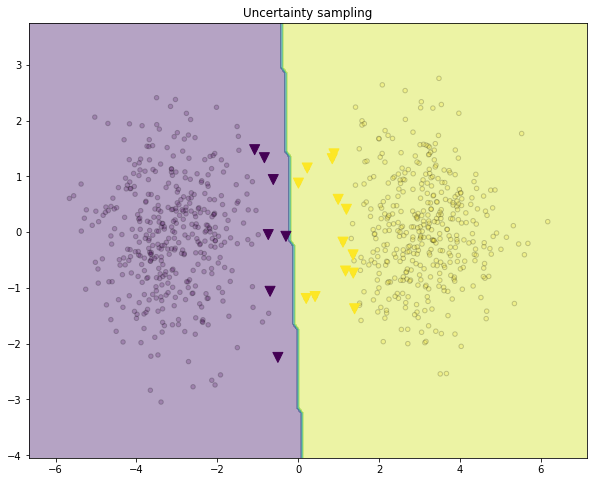

In [85]:


#Initial model
sampleIndex = np.random.choice(X.shape[0], samplesize)
clf = LogisticRegression(random_state=0).fit(X[sampleIndex[:],:], y[sampleIndex[:]])


# Get informative measure for each sample (Predict on all sampling)
predictions = np.amax(clf.predict_proba(X), axis=1)
#print(clf.predict_proba(X)[:30])
predictionsIndex = np.argmax(clf.predict_proba(X), axis=1)
#print(predictionsIndex[:30])

#Query the most uncertain samples
query = X[predictions.argsort()[:samplesize]]
queryLabels =y[predictions.argsort()[:samplesize]]





#print(query)

#Build a model with the actively queried samples

clf = LogisticRegression(random_state=0).fit(query, queryLabels)


#Plot the most uncertain samples with the corresponding decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(sharex='col', sharey='row', figsize=(10, 8))


Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
axarr.contourf(xx, yy, Z, alpha=0.4)
axarr.scatter(X[:, 0], X[:, 1], c=y,s=20, edgecolor='k', alpha =.2)
axarr.scatter(query[:,0], query[:,1], c=queryLabels, s=100, marker = "v")
axarr.set_title('Uncertainty sampling')

plt.show()


## Conclusions

- The queried samples are closer to the decision boundary
- Making a model on the queried samples form a more appropriate decision boundary

## References

[1] Burr (University ofWisconsin–Madison) Settles.“Activer learning literaturesurvey”. In: (2010)

